In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_coverage = 'tme_data/sets/v2_maze/coverage/2'
os.chdir(path_coverage)

In [3]:
def read_text_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()

In [4]:
def neg_size_check(matrix, size):
    result = True
    if(matrix.shape[0] == size):
        result = False
    return result

In [5]:
def matrix_build(matrix, limit):
    result = matrix
    if (neg_size_check(matrix, limit)):
        number = limit-matrix.shape[0]
        if number < 0:
            result = matrix[:limit]
        else:
            temp_2 = np.full(number, matrix[-1])
            result = np.insert(result, -1, temp_2)
    return result

In [6]:
def min_mean_max_extraction(matrix):
    result = np.empty(3)
    result[0] = np.min(matrix)
    result[1] = np.mean(matrix)
    result[2] = np.max(matrix)
    return result

In [7]:
def min_median_max_extraction(matrix):
    result = np.empty(3)
    result[0] = np.min(matrix)
    result[1] = np.median(matrix)
    result[2] = np.max(matrix)
    return result

In [8]:
def matrix_splice(matrix, length):
    result_distance = matrix[:, 0]
    result_count = matrix[:, 0]
    result_distance_sum = matrix[:, 0]
    result_count_sum = matrix[:, 0]

    temp = matrix[:, 1:]

    num_1 = length
    num_2 = length*2
    temp_distance = temp[:, 0:num_1]
    temp_count = temp[:, num_1:num_2]
    temp_distance_sum = np.sum(temp_distance, axis=1)
    temp_count_sum = np.sum(temp_count, axis=1)
    result_distance=np.c_[result_distance, temp_distance]
    result_count=np.c_[result_count, temp_count]
    result_distance_sum = np.c_[result_distance_sum, temp_distance_sum]
    result_count_sum = np.c_[result_count_sum, temp_count_sum]
        
    return result_distance, result_count, result_distance_sum, result_count_sum

In [9]:
def matrix_builder(matrix, distance_matrix, limit):
    temp = []
    for i in range(limit):
        temp.append(i*5)
    temp = np.array(temp)
    result = matrix_build(matrix[0][:, 1], limit)
    result_2 = np.array(temp)
    result_2 = eighty_build_distance(distance_matrix[0][:,1:], limit)
    index_array = []
    for i in range(len(matrix)):
        temp = matrix[i][:, 1]
        temp = matrix_build(temp, limit)
        if(i < distance_matrix.shape[0]):
            temp_2 = distance_matrix[i][:,1:]
            temp_2 = eighty_build_distance(temp_2, limit)
            if (temp[-1] > 0.88):
                test_passed = False
                start_value = -1
                index = 0
                count = 0
                for j in range(limit - 1):
                    if (np.abs(temp[j] - temp[j+1]) < 0.002):
                        if (temp[j+1] - start_value > 0.002):
                            index = j+1
                            start_value = temp[j+1]
                            count = 0
                        if (count >= 20):
                            break
                        count += 1
                    for x in range(len(temp_2[0])):
                        if (np.abs(temp_2[j][x] - temp_2[j+1][x]) > 5):
                            test_passed = True
                if(not test_passed):
                    result = np.c_[result, temp]
                    result_2 = np.c_[result_2, temp_2]
                    index_array.append(index)
    index_array = np.array(index_array)
    return result, result_2, index_array

In [10]:
def eighty_build_distance(matrix, limit):
    result = matrix
    if (neg_size_check(matrix, limit)):
        number = limit-matrix.shape[0]
        if number < 0:
            result = matrix[:limit]
            number = 0
        #temp_2 = np.full((number, 4), matrix[-1][:])
        #temp_2 = np.repeat(matrix[-1], number, axis=0)
        temp_2 = np.tile(matrix[-1], (number, 1))
        result = np.append(result, temp_2)
        result = result.reshape((limit, -1))
    return result

In [11]:
def extract_from_file(eval_method):
    result = []
    
    for file in os.listdir():
        if file.endswith('.txt'):
            file_path =  f"{file}"
            if(eval_method in file_path):
                check = np.loadtxt(file_path)
                if check.any() and check.ndim == 2:
                    result.append(check)

    result = np.array(result)
    return result

In [12]:
def extraction(map_name, robot_num, eval_methods, limit=100, eval_lower=0, eval_upper=-1):
    try: 
        os.chdir(f'../../{map_name}/coverage/{robot_num}')
    except:
        os.chdir(f'../../../{map_name}/coverage/{robot_num}')

    matrix_coverage = []
    len_eval = len(eval_methods)

    for i in range(len_eval):
        matrix_coverage.append(extract_from_file(eval_methods[i]))

    matrix_coverage = np.array(matrix_coverage)

    os.chdir(f'../../../{map_name}/distances/{robot_num}')

    matrix_distance = []

    for i in range(len_eval):
        matrix_distance.append(extract_from_file(eval_methods[i]))

    matrix_distance = np.array(matrix_distance)
        
    c_median = np.empty((len_eval, limit))
    time = np.empty((len_eval, 3))
    c_sum = []
    d_sum = []

    for i in range(len(eval_methods)):
        nearest_c_plot, nearest_d_plot, nearest_time_taken = matrix_builder(matrix_coverage[i], matrix_distance[i], 100)

        time_values_nearest = min_median_max_extraction(nearest_time_taken[eval_lower:eval_upper])
    
        nearest_median = np.median(nearest_c_plot[:, eval_lower:eval_upper], axis=1)
        
        nearest_d, nearest_c, nearest_c_sum, nearest_d_sum = matrix_splice(nearest_d_plot, robot_num)

        nearest_c_sum_median = np.median(nearest_c_sum[:, 1:-1], axis=1)
        
        nearest_d_sum_median = np.median(nearest_d_sum[:, 1:-1], axis=1)
        
        c_median[i] = nearest_median
        time[i] = time_values_nearest
        c_sum.append(nearest_c_sum_median)
        d_sum.append(nearest_d_sum_median)

    c_sum = np.array(c_sum)
    d_sum = np.array(d_sum)

    return c_median, time, c_sum, d_sum


In [30]:
evals = ['coExplore', 'coEuclid', 'combined', 'minPos', 'nearest', 'minEuclid']
eval_length = len(evals)

map_2_a, map_2_b, map_2_c, map_2_d = extraction('map_3', 2, evals)
map_3_a, map_3_b, map_3_c, map_3_d = extraction('map_3', 3, evals)
map_4_a, map_4_b, map_4_c, map_4_d = extraction('map_3', 4, evals)
map_5_a, map_5_b, map_5_c, map_5_d = extraction('map_3', 5, evals)

maze_2_a, maze_2_b, maze_2_c, maze_2_d = extraction('v2_maze', 2, evals)
maze_3_a, maze_3_b, maze_3_c, maze_3_d = extraction('v2_maze', 3, evals)
maze_4_a, maze_4_b, maze_4_c, maze_4_d = extraction('v2_maze', 4, evals)
maze_5_a, maze_5_b, maze_5_c, maze_5_d = extraction('v2_maze', 5, evals)
"""
marty_2_a, marty_2_b, marty_2_c, marty_2_d = extraction('marty', 2, evals)
marty_3_a, marty_3_b, marty_3_c, marty_3_d = extraction('marty', 3, evals)
marty_4_a, marty_4_b, marty_4_c, marty_4_d = extraction('marty', 4, evals)
marty_5_a, marty_5_b, marty_5_c, marty_5_d = extraction('marty', 5, evals) """

"\nmarty_2_a, marty_2_b, marty_2_c, marty_2_d = extraction('marty', 2, evals)\nmarty_3_a, marty_3_b, marty_3_c, marty_3_d = extraction('marty', 3, evals)\nmarty_4_a, marty_4_b, marty_4_c, marty_4_d = extraction('marty', 4, evals)\nmarty_5_a, marty_5_b, marty_5_c, marty_5_d = extraction('marty', 5, evals) "

In [31]:
def mid_compilation(matrix1, matrix2, matrix3, matrix4, index):
    result = [matrix1[index][2], matrix2[index][2], matrix3[index][2], matrix4[index][2]]
    return result

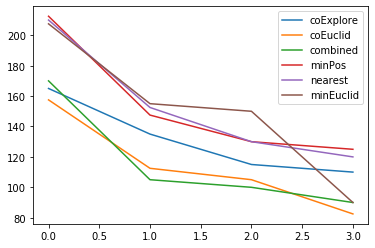

In [32]:
map = np.empty((4, eval_length))
map[0] = map_2_b[:, 1]
map[1] = map_3_b[:, 1]
map[2] = map_4_b[:, 1]
map[3] = map_5_b[:, 1]
map = map * 5
plt.plot(map[:,0], label='coExplore')
plt.plot(map[:,1], label='coEuclid')
plt.plot(map[:,2], label='combined')
plt.plot(map[:,3], label='minPos')
plt.plot(map[:,4], label='nearest')
plt.plot(map[:,5], label='minEuclid')
plt.legend()
plt.show()

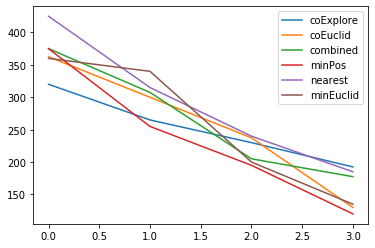

In [33]:
maze = np.empty((4, eval_length))
maze[0] = maze_2_b[:, 1]
maze[1] = maze_3_b[:, 1]
maze[2] = maze_4_b[:, 1]
maze[3] = maze_5_b[:, 1]
maze = maze * 5
plt.plot(maze[:,0], label='coExplore')
plt.plot(maze[:,1], label='coEuclid')
plt.plot(maze[:,2], label='combined')
plt.plot(maze[:,3], label='minPos')
plt.plot(maze[:,4], label='nearest')
plt.plot(maze[:,5], label='minEuclid')
plt.legend()
plt.show()

In [17]:
marty = np.empty((4, eval_length))
marty[0] = marty_2_b[:, 1]
marty[1] = marty_3_b[:, 1]
marty[2] = marty_4_b[:, 1]
marty[3] = marty_5_b[:, 1]
marty = marty * 5
plt.plot(marty[:,0], label='nearest')
plt.plot(marty[:,1], label='minPos')
plt.plot(marty[:,2], label='coExplore')
plt.legend()
plt.show()

NameError: name 'marty_2_b' is not defined